In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def regress(ax, x, y, x1, x2, y1, y2, t_label=20, color='r') :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(x, y)
    x_test = np.linspace(np.min(x), np.max(x), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=color, linewidth=2)
    ax.text(x2-(x2-x1)/10,y1+(y2-y1)/10, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    return ax

In [3]:
sujets = ['AM','BMC'] #,'CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']

In [4]:
def comparaison() :
    list_param_enre = ['start_anti', 'v_anti', 'latence', 'maxi']

    fig, axs = plt.subplots(1, len(list_param_enre), figsize=(5*len(list_param_enre), (5/1.6180)))
    for i, param in enumerate(list_param_enre) :
        old, new = [], []
        for s in sujets :
            with open('parametre/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%s, 'rb') as fichier :
                param_old = pickle.load(fichier, encoding='latin1')

            with open('param_Fit_%s_new_velocity.pkl'%s, 'rb') as fichier :
                param_new = pickle.load(fichier, encoding='latin1')
            
            
            for block in range(3) :
                old.extend(param_old[param][block])
                new.extend(param_new[param][block])

        axs[i].scatter(old, new, c='k', s=10, alpha=0.4)
        axs[i] = regress(axs[i], old, new, min(old), max(old), min(new), max(new), t_label=20, color='r')

        axs[i].set_xlabel('old_fit')
        axs[i].set_ylabel('new_fit')
        axs[i].set_title('%s - old : %0.1f - new : %0.1f'%(param, np.mean(old), np.mean(new)))

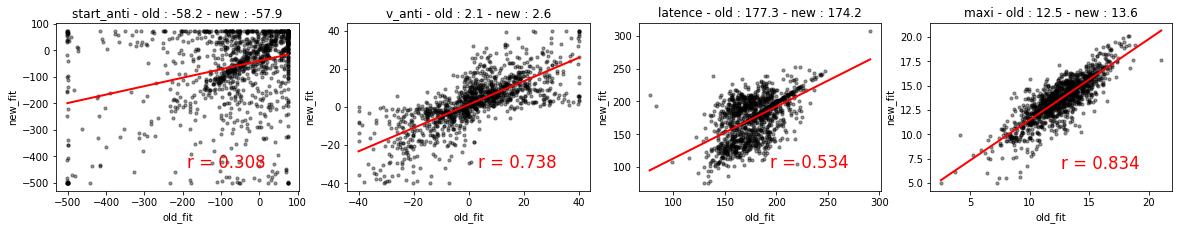

In [5]:
comparaison()